# Capstone Project Flask UI

Pada capstone ini, anda diminta untuk membangun sebuah UI sederhana menggunakan **Flask** yang berisi beberapa tampilan plot dari skeleton yang sudah disediakan dan satu plot tambahan berdasarkan analisis anda.

File ini dapat dimanfaatkan untuk membantu anda dalam proses wrangling dan visualization. Apabila proses wrangling sudah tepat dan hasil visualisasi sudah sesuai dengan ketentuan, anda dapat memindahkan kembali kode program yang sudah anda lengkapi ke dalam file `app.py`.

## Create Virtual Enviroment 

**1. Buat virtual environment bernama `capstone-flask`**

Hal pertama yang harus dilakukan adalah melakukan pengaturan environment conda. Untuk menyiapkan conda environment dan kernel, silahkan gunakan command berikut:

```
conda create -n capstone-flask python=3.10
conda activate capstone-flask
```
<br>

**2. Install library yang dibutuhkan: `pandas`, `flask`, `matplotlib`, dan `numpy`**

Seluruh dependecies telah di-export ke dalam file requirements.txt. Oleh karena itu untuk melakukan instalasi library, Anda dapat menggunakan perintah berikut:

```
pip install -r requirements.txt --user
```
<br>


## Data Preprocessing

**Import library**

In [3]:
from flask import Flask, render_template
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
import base64

**Load data**

Silahkan read file `googleplaystore.csv` dalam bentuk dataframe dan simpan pada variabel `playstore`

In [4]:
playstore = pd.read_csv('data/googleplaystore.csv')

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10836,Sya9a Maroc - FR,FAMILY,4.5,38,53M,"5,000+",Free,0,Everyone,Education,"July 25, 2017",1.48,4.1 and up
10837,Fr. Mike Schmitz Audio Teachings,FAMILY,5.0,4,3.6M,100+,Free,0,Everyone,Education,"July 6, 2018",1.0,4.1 and up
10838,Parkinson Exercices FR,MEDICAL,NaN,3,9.5M,"1,000+",Free,0,Everyone,Medical,"January 20, 2017",1.0,2.2 and up
10839,The SCP Foundation DB fr nn5n,BOOKS_AND_REFERENCE,4.5,114,Varies with device,"1,000+",Free,0,Mature 17+,Books & Reference,"January 19, 2015",Varies with device,Varies with device


**Data Cleansing** 

**_Task 1:_** Hapus data duplikat berdasarkan kolom App, dengan tetap keep data pertama (hint : gunakan parameter subset)

In [5]:
playstore = playstore.drop_duplicates(subset = ['App'], keep='first') 

Silahkan jalankan code berikut ini untuk menghapus data baris 10472 karena nilai pada baris tersebut tidak tersimpan pada kolom yang benar (**tidak perlu diubah**)

In [6]:
playstore.loc[[10472]]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN


In [7]:
playstore = playstore.drop([10472])

**_Task 2:_** Cek tipe data kolom Category. Jika masih tersimpan dengan format tipe data yang salah, ubah ke tipe data yang sesuai


In [8]:
playstore['Category'] = playstore['Category'].astype('category')

**_Task 3:_** Pada kolom `Installs`, buang tanda koma (,) dan tanda tambah (+) kemudian ubah tipe data menjadi integer

In [9]:
playstore['Installs'] = playstore['Installs'].apply(lambda x: x.replace(',',''))
playstore['Installs'] = playstore['Installs'].apply(lambda x: x.replace('+',''))

playstore['Installs'] = playstore['Installs'].astype('int64')

Silahkan jalankan code berikut ini untuk merapikan kolom Size, Anda tidak perlu mengubah apapun di bagian ini

In [10]:
playstore['Size'].replace('Varies with device', np.nan, inplace = True ) 
playstore['Size'] = playstore['Size'].replace(r'[kM]+$', '', regex=True).astype(float) * \
                    playstore['Size'].str.extract(r'[\d\.]+([kM]+)', expand=False) \
                    .fillna(1)\
                    .replace(['k','M'], [10**3, 10**6]).astype(int)
playstore['Size'].fillna(playstore.groupby('Category')['Size'].transform('mean'),inplace = True)


**_Task 4:_** Pada kolom `Price`, buang karakter $ pada nilai `Price` lalu ubah tipe datanya menjadi float

In [11]:
playstore['Price'] = playstore['Price'].apply(lambda x: x.replace('$',''))
playstore['Price'] = playstore['Price'].astype('float64')

Ubah tipe data `Reviews` dan `Size` ke dalam tipe data integer

In [12]:
## code here
playstore[['Reviews', 'Size']] = playstore[['Reviews', 'Size']].astype('int64')


## Data Wrangling

In [13]:
df2 = playstore.copy()

**_Task 5:_** Dataframe top_category dibuat untuk menyimpan frekuensi aplikasi untuk setiap data pada kolom `Category`. 

1. Gunakan `crosstab` untuk menghitung frekuensi aplikasi di setiap category
2. Berikan nama `Jumlah` sebagai nama kolom
3. Urutkan nilai frekuensi dari nilai yang paling besar ke paling kecil. 
4. Reset index dari dataframe `top_category`.

In [76]:
top_category = pd.crosstab(index = df2['Category'],
                           columns = 'Jumlah').sort_values(by = 'Jumlah', ascending = False).reset_index()

In [15]:
top_category.head()

col_0,Category,Jumlah
0,FAMILY,1832
1,GAME,959
2,TOOLS,827
3,BUSINESS,420
4,MEDICAL,395


**_Task 6:_** Ini adalah bagian untuk melengkapi konten value box 
- Isi `most_categories` dengan nama `Category` dengan frekuensi terbanyak mengacu pada dataframe `top_category`
- isi `total` dengan nilai frekuensi dari `Category` terbanyak mengacu pada dataframe `top_category`

In [16]:
most_categories = top_category.Category.iloc[0]
total = top_category.Jumlah.iloc[0]

`rev_table` adalah tabel yang berisi 10 aplikasi yang paling banyak direview oleh pengguna.

Silahkan melakukan proses yang tepat untuk menampilkan 10 aplikasi dengan jumlah Review pengguna terbanyak. Tabel yang ditampilkan terdiri dari 4 kolom yaitu nama `Category`, nama `App`, jumlah `Reviews`, dan nilai `Rating`.


In [17]:

rev_table = df2.groupby(['Category','App']).agg({'Reviews' : 'sum', 'Rating' : 'mean'}).sort_values(by='Reviews', ascending= False).reset_index().head(10)
rev_table

,Category,App,Reviews,Rating
0,SOCIAL,Facebook,78158306,4.1
1,COMMUNICATION,WhatsApp Messenger,69119316,4.4
2,SOCIAL,Instagram,66577313,4.5
3,COMMUNICATION,Messenger – Text and Video Chat for Free,56642847,4.0
4,GAME,Clash of Clans,44891723,4.6
5,TOOLS,Clean Master- Space Cleaner & Antivirus,42916526,4.7
6,GAME,Subway Surfers,27722264,4.5
7,VIDEO_PLAYERS,YouTube,25655305,4.3
8,TOOLS,"Security Master - Antivirus, VPN, AppLock, Boo...",24900999,4.7
9,GAME,Clash Royale,23133508,4.6


Apabila menuliskan kode program yang tepat maka hasil wrangling adalah sebagai berikut :

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Category</th>
      <th>App</th>
      <th>Reviews</th>
      <th>Rating</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>SOCIAL</td>
      <td>Facebook</td>
      <td>78158306</td>
      <td>4.1</td>
    </tr>
    <tr>
      <th>1</th>
      <td>COMMUNICATION</td>
      <td>WhatsApp Messenger</td>
      <td>69119316</td>
      <td>4.4</td>
    </tr>
    <tr>
      <th>2</th>
      <td>SOCIAL</td>
      <td>Instagram</td>
      <td>66577313</td>
      <td>4.5</td>
    </tr>
    <tr>
      <th>3</th>
      <td>COMMUNICATION</td>
      <td>Messenger – Text and Video Chat for Free</td>
      <td>56642847</td>
      <td>4.0</td>
    </tr>
    <tr>
      <th>4</th>
      <td>GAME</td>
      <td>Clash of Clans</td>
      <td>44891723</td>
      <td>4.6</td>
    </tr>
    <tr>
      <th>5</th>
      <td>TOOLS</td>
      <td>Clean Master- Space Cleaner &amp; Antivirus</td>
      <td>42916526</td>
      <td>4.7</td>
    </tr>
    <tr>
      <th>6</th>
      <td>GAME</td>
      <td>Subway Surfers</td>
      <td>27722264</td>
      <td>4.5</td>
    </tr>
    <tr>
      <th>7</th>
      <td>VIDEO_PLAYERS</td>
      <td>YouTube</td>
      <td>25655305</td>
      <td>4.3</td>
    </tr>
    <tr>
      <th>8</th>
      <td>TOOLS</td>
      <td>Security Master - Antivirus, VPN, AppLock, Boo...</td>
      <td>24900999</td>
      <td>4.7</td>
    </tr>
    <tr>
      <th>9</th>
      <td>GAME</td>
      <td>Clash Royale</td>
      <td>23133508</td>
      <td>4.6</td>
    </tr>
  </tbody>
</table>
</div>

## Data Visualization

**Membuat Bar Plot**

**_Task 7:_** 
Lengkapi tahap agregasi untuk membuat dataframe yang mengelompokkan jumlah aplikasi berdasarkan Category. Buatlah bar plot dengan ketentuan:
- axis **`y`** adalah nama `Category`
- axis **`x`** adalah jumlah aplikasi pada setiap kategori yang telah diurutkan dari jumlah terbanyak

Apabila menuliskan kode program yang tepat, maka akan menghasilkan visualisasi sebagai berikut: 
<br><br>
![cat_order.png](cat_order.png)

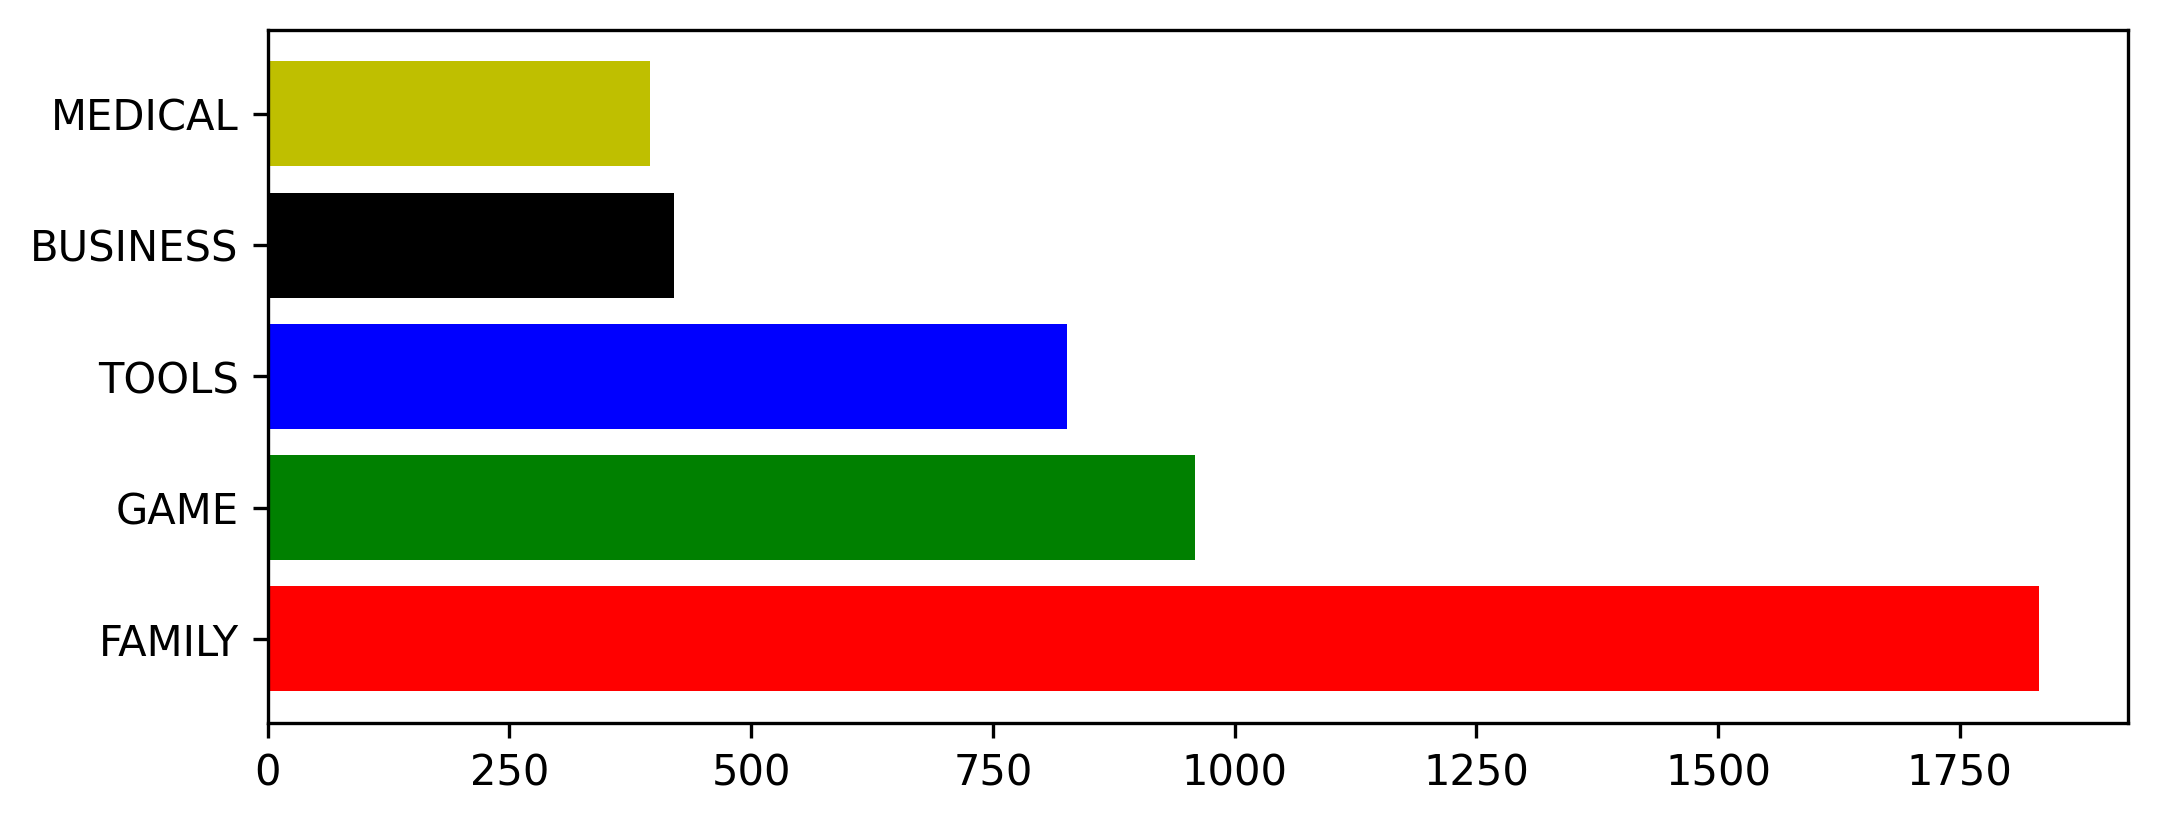

In [18]:
cat_order = df2.groupby('Category').agg({
    'Category' : 'count'
    }).rename({'Category':'Total'}, axis=1).sort_values(by= 'Total', ascending= False).reset_index().head()

X = cat_order['Category']
Y = cat_order['Total']

my_colors = ['r','g','b','k','y','m','c']
# bagian ini digunakan untuk membuat kanvas/figure
fig = plt.figure(figsize=(8,3),dpi=300)
fig.add_subplot()

# bagian ini digunakan untuk membuat bar plot
plt.barh(y=X, width=Y, color=my_colors)

# bagian ini digunakan untuk menyimpan plot dalam format image.png
plt.savefig('cat_order.png',bbox_inches="tight") 

**Membuat Scatter Plot**

**_Task 8:_** Buatlah scatter plot untuk menampilkan hubungan dan persebaran apalikasi dilihat dari Review vs Rating. Kemudian, ubah ukuran tiap lingkaran pada scatter plot sehingga dapat menggambarkan berapa banyak pengguna yang telah menginstall aplikasi

Apabila menuliskan kode program yang tepat, maka akan menghasilkan visualisasi sebagai berikut: 
<br><br>
![rev_rat.png](rev_rat.png)

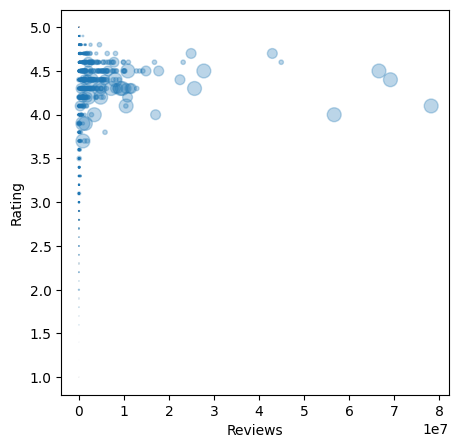

In [19]:
X = df2['Reviews'].values # axis x
Y = df2['Rating'].values # axis y
area = df2['Installs'].values/10000000 # ukuran besar/kecilnya lingkaran scatter plot

fig = plt.figure(figsize=(5,5))
fig.add_subplot()

# isi nama method untuk scatter plot, variabel x, dan variabel y
plt.scatter(x=X,y=Y, s=area, alpha=0.3)
plt.xlabel('Reviews')
plt.ylabel('Rating')
plt.savefig('rev_rat.png',bbox_inches="tight")

**Membuat Histogram Size Distribution**

**_Task 9:_** Buatlah sebuah histogram yang menggambarkan distribusi Size aplikasi dalam satuan Mb(Megabytes). Histogram yang terbentuk terbagi menjadi 100 bins

Apabila menuliskan kode program yang tepat, maka akan menghasilkan visualisasi sebagai berikut: 
<br><br>
![hist_size.png](hist_size.png)

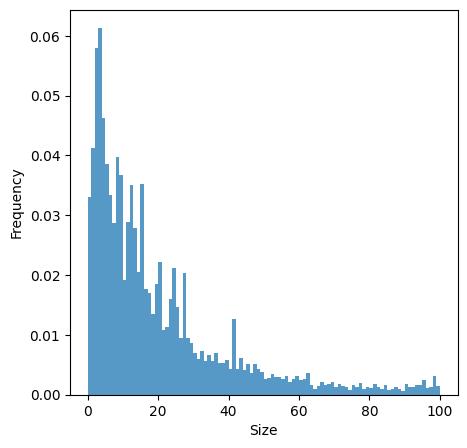

In [20]:
X=(df2['Size']/1000000).values
fig = plt.figure(figsize=(5,5))
fig.add_subplot()
plt.hist(X ,bins=100, density=True,  alpha=0.75)
plt.xlabel('Size')
plt.ylabel('Frequency')
plt.savefig('hist_size.png',bbox_inches="tight")

**_Task 10:_** Buatlah plot berdasarkan hasil analisis anda. Plot yang dibuat tidak diperbolehkan sama dengan plot yang sudah dicontohkan.

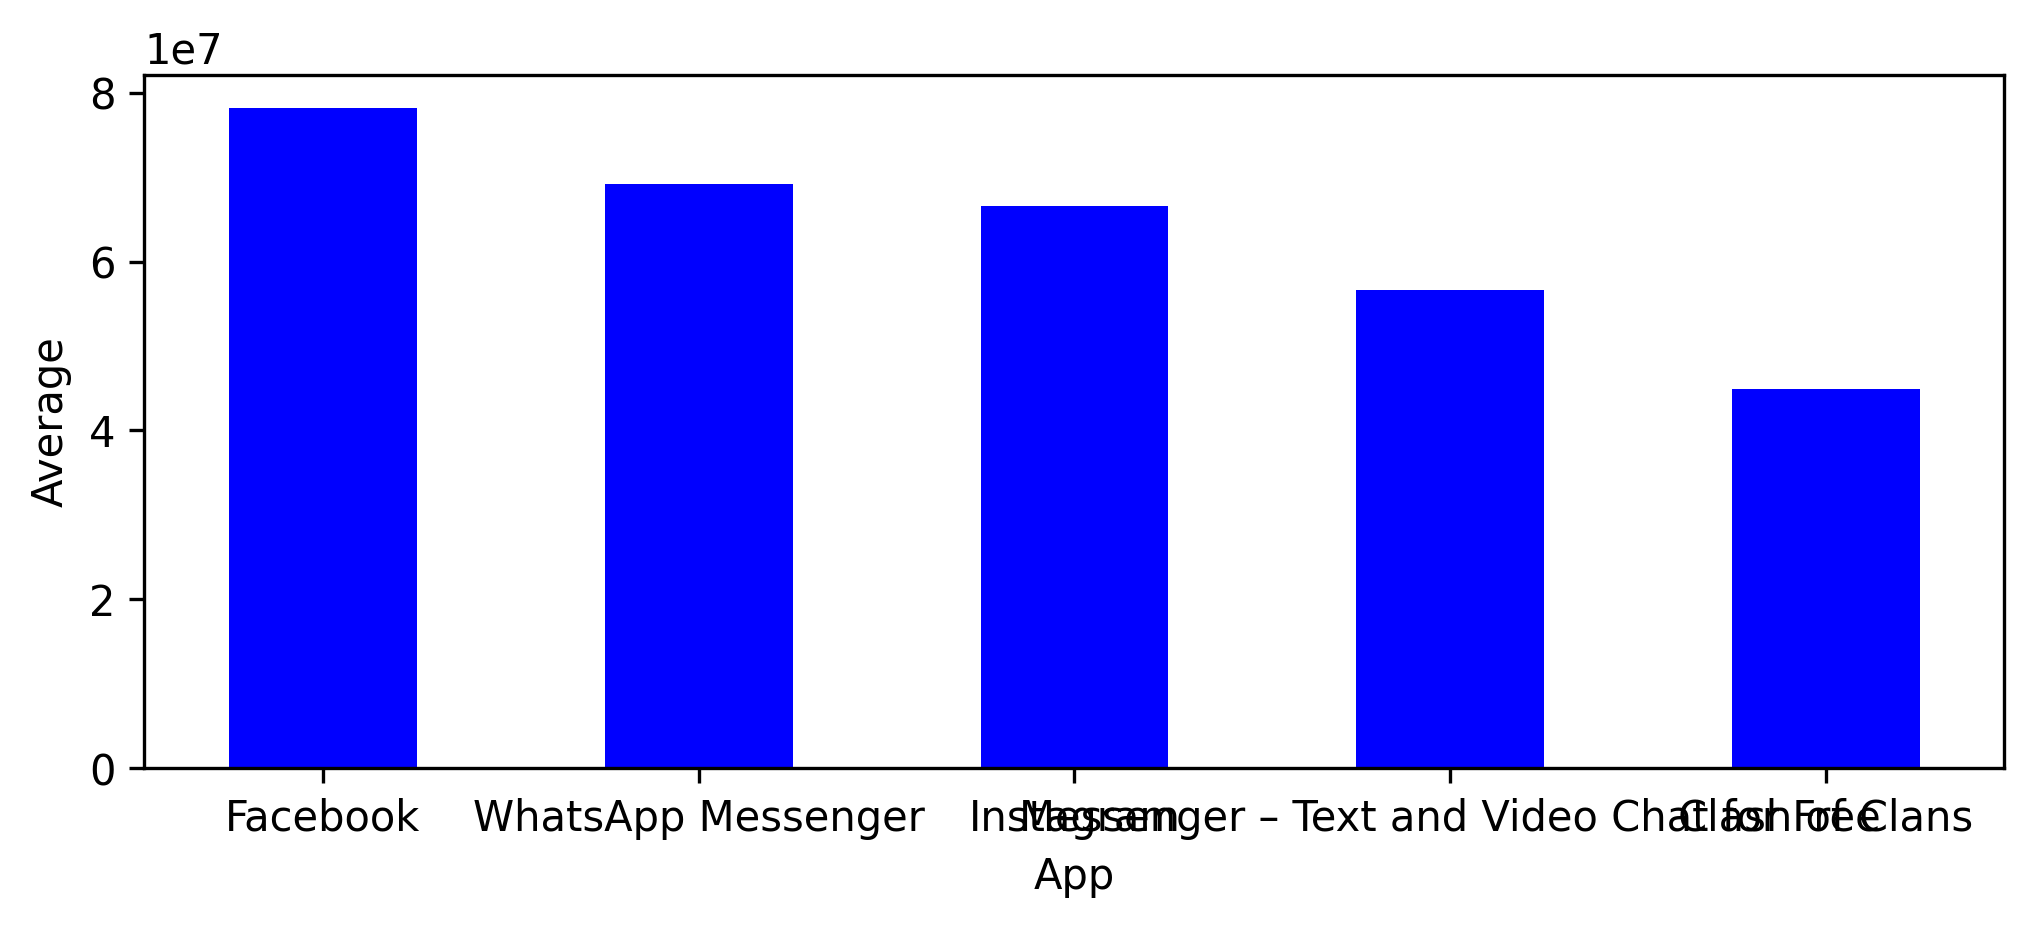

In [75]:
## code here
top_app = df2.groupby('App').agg({
    'Reviews' : 'mean'
    }).rename({'Reviews':'Average'}, axis=1).sort_values(by= 'Average', ascending= False).reset_index().head()

X = top_app['App']
Y = top_app['Average']

fig = plt.figure(figsize=(8,3),dpi=300)
fig.add_subplot()

plt.bar(X, Y, color='blue', width=0.5)
plt.xlabel('App')
plt.ylabel('Average')

plt.savefig('top_app.png',bbox_inches="tight") 
